# HDDM analysis of pre- and post-treatment data from 43 HCs and 38 MDD adolescent females

[Cleaning](#Cleaning)  
[Baseline](#Baseline)   
[Follow Up](#Follow-Up)  

In [268]:
import datetime, mmap,os,re, sys, decimal, hddm, glob
import numpy as np 
import pandas as pd
import seaborn as sns 
import matplotlib.pyplot as plt
import scipy as sp
from patsy import dmatrix
%matplotlib inline
import warnings 
warnings.filterwarnings('ignore')
os.environ['R_HOME'] = '/Users/mlm2/anaconda/envs/pythonthreefive/lib/R' # couldn't find R in this environment for some reason
% matplotlib inline 
% load_ext rpy2.ipython
%R library(lsmeans)
%R library(lmerTest)
%R library(afex)
%R library(ppcor)
%R library(cocor)

The rpy2.ipython extension is already loaded. To reload it, use:
  %reload_ext rpy2.ipython


array(['cocor', 'ppcor', 'MASS', 'afex', 'reshape2', 'lmerTest', 'lme4',
       'Matrix', 'lsmeans', 'estimability', 'tools', 'stats', 'graphics',
       'grDevices', 'utils', 'datasets', 'methods', 'base'], 
      dtype='<U12')

In [269]:
uname = !whoami
uname = uname[0]
path2data = '/Users/victorialawlor/Work/Expts/KIDPRT/Data/'

# Cleaning

For sub DTC066 (CTL) we have data from three sessions on 12/2/16, 1/21/17, and 3/13/17. The last two are combined into the same file. Excluding subject for now.

In [489]:
def SigDetParse(fname):
    '''Open the file, pull out key vars, output a clean df.'''
    
    df = []
    d = {}
    ct = 0

    with open(fname) as f:
        f = f.readlines()[17:]
        for line in f:
            #print(line)
            #print(line.split(' '))
            d[ct] = {'trial':line.split(' ')[1],
                     'length':line.split(' ')[2],
                     'rt':line.split(' ')[3], 
                     'key_press':line.split(' ')[4],
                     'correct':line.split(' ')[7],
                     'did_reward':line.split(' ')[9],
                     'reward_due':line.split(' ')[11],
                     'little_due':line.split(' ')[13],
                     'big_due':line.split(' ')[15].strip('\n')}
            ct = ct + 1

    df = pd.DataFrame.from_dict(d,orient='index')
    
    with open(fname) as f:
        for line in f:
            if line.count(':') == 1:
                value = ''
                label = line.split(':')[0]
                label = label.replace(' ', '_')
                value = line.split(':')[1].strip('\n').replace('{','').strip('}')
                df[label] = value
                df['subjectID'] = fname[50:56]
                df['file_session'] = fname[59]
                df['group'] = df.subjectID.str[:3]
                df.loc[df.group == 'DTC', 'group'] = 'CTL'
                df.loc[df.group == 'DTD', 'group'] = 'MDD'
    return df

In [490]:
dfs = []
files = (glob.glob(path2data + '/Raw/DT*/*-.txt'))
for file in files:
    df = SigDetParse(file)
    dfs.append(df)
out = pd.DataFrame
out = pd.concat(dfs)
out.head(10)
out.rename(columns={'Subject':'subject', 'Session':'session', 'Short_Key':'short_key', 
                    'Long_Key':'long_key', 'Bias':'bias'}, inplace=True)
out.to_csv(path2data + 'trial_all.csv')

In [491]:
# Checking number of subjects, this lines up with what Randy gave us (38 mdds completed session 1 but DTD510 was 
# later found ineligible)

print(out.groupby('group').subjectID.nunique())
out.subjectID.unique()

group
CTL    43
MDD    37
Name: subjectID, dtype: int64


array(['DTC020', 'DTC021', 'DTC022', 'DTC023', 'DTC024', 'DTC025',
       'DTC026', 'DTC027', 'DTC029', 'DTC030', 'DTC031', 'DTC033',
       'DTC034', 'DTC035', 'DTC036', 'DTC037', 'DTC038', 'DTC039',
       'DTC040', 'DTC041', 'DTC042', 'DTC043', 'DTC044', 'DTC045',
       'DTC047', 'DTC048', 'DTC049', 'DTC050', 'DTC051', 'DTC052',
       'DTC053', 'DTC054', 'DTC056', 'DTC058', 'DTC059', 'DTC060',
       'DTC061', 'DTC062', 'DTC063', 'DTC064', 'DTC065', 'DTC066',
       'DTC067', 'DTD511', 'DTD513', 'DTD516', 'DTD518', 'DTD519',
       'DTD520', 'DTD521', 'DTD525', 'DTD526', 'DTD529', 'DTD530',
       'DTD531', 'DTD532', 'DTD533', 'DTD534', 'DTD535', 'DTD536',
       'DTD537', 'DTD538', 'DTD539', 'DTD540', 'DTD542', 'DTD543',
       'DTD544', 'DTD548', 'DTD549', 'DTD550', 'DTD551', 'DTD552',
       'DTD554', 'DTD556', 'DTD560', 'DTD561', 'DTD562', 'DTD564',
       'DTD565', 'DTD567'], dtype=object)

In [492]:
# splitting up by sessions
session1 = out.loc[out.session == '1']
session2 = out.loc[out.session == '2']

In [493]:
# looks correct
session1.groupby('group').subjectID.nunique()

group
CTL    43
MDD    37
Name: subjectID, dtype: int64

In [494]:
# missing 4 ctls originally, DTC065 was entered as DTC066 which explained
# two of those, I fixed by hand and reran sigdetparse. 
# We are still missing 2 healthy controls
session2.groupby('group').subjectID.nunique()

group
CTL    36
MDD    23
Name: subjectID, dtype: int64

In [495]:
# We don't have a list of controls who completed/didn't complete to compare to, should
# try to get that from Randy

for item in session1.loc[session1.group == 'CTL'].subjectID.unique():
    if item in session2.loc[session2.group == 'CTL'].subjectID.unique():
        pass
    else:
        print(item)

DTC027
DTC029
DTC030
DTC041
DTC043
DTC048
DTC054


In [496]:
session1.to_csv(path2data + 'trial_session1.csv')
session2.to_csv(path2data + 'trial_session2.csv')

## Session 1

In [505]:
# adding rich and lean columns, blocks
out = pd.read_csv(path2data + 'trial_session1.csv')
out['subject'] = out.subjectID
data = out.reset_index()
del data['Unnamed: 0']

data.bias = data.bias.apply(lambda x: x.strip(' '))
data.trial = data.trial.apply(lambda x: int(x))
data['rl_stim'] = ''
data.loc[data['length'] == data['bias'], 'rl_stim'] = 'rich_stim'
data.loc[data['length'] != data['bias'], 'rl_stim'] = 'lean_stim'

data['rich_key'] = ''
data.loc[data['bias'] == 'short', 'rich_key'] = data['short_key']
data.loc[data['bias'] == 'long', 'rich_key'] = data['long_key']
data.rich_key = data.rich_key.apply(lambda x: x.strip(' '))

data['rl_resp'] = ''
data.loc[data['key_press'] == data['rich_key'], 'rl_resp'] = 'rich_resp'
data.loc[data['key_press'] != data['rich_key'], 'rl_resp'] = 'lean_resp'

data['block'] = 0
data.loc[data.trial <= 200, 'block'] = 2
data.loc[data.trial <= 100, 'block'] = 1

#### Quality control (trials):
"PRT trials were considered outliers and excluded from analysis if the raw RT was less than 150 ms or greater than 2500 ms, or if the log transformed RT was greater than 3 S.D.s from the participant’s mean."

In [506]:
# Mark trials as outliers if 150 > time > 2500

data.rt = data.rt.apply(lambda x: int(x))
data['ln_rt'] = data.rt.apply(np.log)
data['outlier'] = 0
data.loc[(data['rt'] > 2500) | (data['rt'] < 150), 'outlier'] = 1

cleandata = data[data.outlier == 0]
data['mean_ln_rt'] = 0 # make columns of interest
data['ln_std'] = 0
for sub in data.subjectID.unique():
    mean = cleandata[cleandata.subjectID == sub].ln_rt.mean()
    std = cleandata[cleandata.subjectID == sub].ln_rt.std()
    data.loc[data.subjectID == sub, 'mean_ln_rt'] = mean
    data.loc[data.subjectID == sub, 'ln_std'] = std
    
# Mark trials as outliers if the ln rt is > 3sd from the mean

data.loc[(data.ln_rt > (3*data.ln_std + data.mean_ln_rt)), 'outlier'] = 1

#### Quality control (subjects):
"Additionally, participants with more than 20 outlier trials in each block, less than 24 rich or 7 lean rewards in each block, less than a 2.5 rich-to-lean reward ratio in either block, or accuracy less than 0.4 for rich or lean trials in either block were excluded from analysis."

In [507]:
data.to_csv('help.csv')

In [508]:
data.did_reward = data.did_reward.apply(lambda x: int(x))
data.correct = data.correct.apply(lambda x: int(x))
data['outlier_sub'] = 0
for subject in data.subjectID.unique():
    for block in data.block.unique():
        
        noutliers = data[(data.subject == subject) & (data.block == block)].outlier.sum()
        
        nrichrew = data[(data.subject == subject) & (data.rl_stim == 'rich_stim') & (data.block == block)].did_reward.sum()
        nleanrew = data[(data.subject == subject) & (data.rl_stim == 'lean_stim') & (data.block == block)].did_reward.sum()
        ratio = nrichrew/nleanrew
        rhaccuracy = data[(data.subject == subject) & (data.rl_stim == 'rich_stim') & (data.block == block)].correct.sum()
        rhcount = data[(data.subject == subject) & (data.rl_stim == 'rich_stim') & (data.block == block)].correct.count()
        lnaccuracy = data[(data.subject == subject) & (data.rl_stim == 'lean_stim') & (data.block == block)].correct.sum()
        lncount = data[(data.subject == subject) & (data.rl_stim == 'lean_stim') & (data.block == block)].correct.count()
        if noutliers > 20:
            print(noutliers)
            print ('Subject ' + str(subject) + ' was excluded for having more than 20 outlier trials')
            data.loc[data.subject == subject, 'outlier_sub'] = 1
        elif nrichrew < 24:
            data.loc[data.subject == subject, 'outlier_sub'] = 1 # mark participants as outliers if they have 
                                                                 # less than 24 rewarded rich trials
            print('Subject ' + str(subject) + ' was excluded for having too few rich rewarded trials')
        elif nleanrew < 7:
            data.loc[data.subject == subject, 'outlier_sub'] = 1 # mark participants as outliers if they have 
                                                                 # less than 7 rewarded lean trials
            print('Subject ' + str(subject) + ' was excluded for having too few lean rewarded trials')
        elif rhaccuracy < (.4*rhcount) or lnaccuracy < (.4*lncount):
            data.loc[data.subject == subject, 'outlier_sub'] = 1 # mark participants as outliers if they have 
                                                                 # less than 7 rewarded lean trials
            print('Subject ' + str(subject) + ' was excluded for low accuracy')
        

25
Subject DTC031 was excluded for having more than 20 outlier trials
33
Subject DTC031 was excluded for having more than 20 outlier trials
Subject DTC038 was excluded for low accuracy
Subject DTC047 was excluded for having too few rich rewarded trials
Subject DTC056 was excluded for having too few rich rewarded trials
Subject DTC060 was excluded for low accuracy
Subject DTD526 was excluded for low accuracy
28
Subject DTD531 was excluded for having more than 20 outlier trials
28
Subject DTD531 was excluded for having more than 20 outlier trials
Subject DTD534 was excluded for having too few rich rewarded trials
Subject DTD543 was excluded for having too few rich rewarded trials
Subject DTD543 was excluded for low accuracy


In [509]:
# take only the clean data
data = data[data.outlier == 0]
data = data[data.outlier_sub == 0]
data.subjectID.nunique() 

71

In [510]:
data.to_csv('/Users/victorialawlor/Work/Expts/KIDPRT/Data/session1_trial_clean.csv')

In [511]:
data = pd.read_csv('/Users/victorialawlor/Work/Expts/KIDPRT/Data/session1_trial_clean.csv')

### Calculate RB & Discriminability

In [350]:
def calc_rb(subject, data):
    '''Given a subject and dataframe, returns the discriminability and response bias for the subject'''
    rh_correct = data[(data.subject == subject) & (data.rl_stim == 'rich_stim')].correct.sum() + .5
    rh_incorrect = data[(data.subject == subject) & (data.rl_stim == 'rich_stim') & (data.correct == 0)].correct.count() + .5
    ln_correct = data[(data.subject == subject) & (data.rl_stim == 'lean_stim')].correct.sum() + .5
    ln_incorrect = data[(data.subject == subject) & (data.rl_stim == 'lean_stim') & (data.correct == 0)].correct.count() + .5
    
    rb = .5 * np.log10((rh_correct * ln_incorrect)/(rh_incorrect * ln_correct))
    disc = .5 * np.log10((rh_correct * ln_correct)/(rh_incorrect * ln_incorrect))
    
    return(rb, disc)

In [351]:
for subject in data.subject.unique():
    rb, disc = calc_rb(subject, data)
    data.loc[data.subject == subject, 'RB_adjst_all_total'] = rb
    data.loc[data.subject == subject, 'dis_adjst_all_total'] = disc
    for block in data.block.unique():
        rb, disc = calc_rb(subject, data[data.block == block])
        data.loc[(data.subject == subject) & (data.block == block), 'RB_adjst_all_block'] = rb
        data.loc[(data.subject == subject) & (data.block == block), 'dis_adjst_all_block'] = disc  
for subject in data.subject.unique():
    block1_rb = data[(data.subject == subject) & (data.block == 1)].RB_adjst_all_block.mean()
    block2_rb = data[(data.subject == subject) & (data.block == 2)].RB_adjst_all_block.mean()
    b2_minus_b1 = block2_rb - block1_rb
    data.loc[data.subject == subject, 'RB_b2_minus_b1'] = b2_minus_b1

In [352]:
data.head()

,Unnamed: 0,Unnamed: 0.1,index,rt,little_due,big_due,trial,reward_due,did_reward,length,...,ln_rt,outlier,mean_ln_rt,ln_std,outlier_sub,RB_adjst_all_total,dis_adjst_all_total,RB_adjst_all_block,dis_adjst_all_block,RB_b2_minus_b1
0,0,0,0,670,0,0,1,1,1,short,...,6.507278,0,6.111284,0.277035,0,-0.210782,0.670529,0.068238,0.767208,-0.535316
1,1,1,1,748,0,1,2,1,0,long,...,6.617403,0,6.111284,0.277035,0,-0.210782,0.670529,0.068238,0.767208,-0.535316
2,2,2,2,885,0,1,3,0,0,short,...,6.785588,0,6.111284,0.277035,0,-0.210782,0.670529,0.068238,0.767208,-0.535316
3,3,3,3,680,0,1,4,1,1,long,...,6.522093,0,6.111284,0.277035,0,-0.210782,0.670529,0.068238,0.767208,-0.535316
4,4,4,4,869,0,1,5,0,0,short,...,6.767343,0,6.111284,0.277035,0,-0.210782,0.670529,0.068238,0.767208,-0.535316


## Session 2


In [392]:
# adding rich and lean columns, blocks
out = pd.read_csv(path2data + 'trial_session2.csv')
out['subject'] = out.subjectID
data = out.reset_index()
del data['Unnamed: 0']

data.bias = data.bias.apply(lambda x: x.strip(' '))
data.trial = data.trial.apply(lambda x: int(x))
data['rl_stim'] = ''
data.loc[data['length'] == data['bias'], 'rl_stim'] = 'rich_stim'
data.loc[data['length'] != data['bias'], 'rl_stim'] = 'lean_stim'

data['rich_key'] = ''
data.loc[data['bias'] == 'short', 'rich_key'] = data['short_key']
data.loc[data['bias'] == 'long', 'rich_key'] = data['long_key']
data.rich_key = data.rich_key.apply(lambda x: x.strip(' '))

data['rl_resp'] = ''
data.loc[data['key_press'] == data['rich_key'], 'rl_resp'] = 'rich_resp'
data.loc[data['key_press'] != data['rich_key'], 'rl_resp'] = 'lean_resp'

data['block'] = 0
data.loc[data.trial <= 200, 'block'] = 2
data.loc[data.trial <= 100, 'block'] = 1

#### Quality control (trials):
"PRT trials were considered outliers and excluded from analysis if the raw RT was less than 150 ms or greater than 2500 ms, or if the log transformed RT was greater than 3 S.D.s from the participant’s mean."

In [393]:
# Mark trials as outliers if 150 > time > 2500

data.rt = data.rt.apply(lambda x: int(x))
data['ln_rt'] = data.rt.apply(np.log)
data['outlier'] = 0
data.loc[(data['rt'] > 2500) | (data['rt'] < 150), 'outlier'] = 1

cleandata = data[data.outlier == 0]
data['mean_ln_rt'] = 0 # make columns of interest
data['ln_std'] = 0
for sub in data.subjectID.unique():
    mean = cleandata[cleandata.subjectID == sub].ln_rt.mean()
    std = cleandata[cleandata.subjectID == sub].ln_rt.std()
    data.loc[data.subjectID == sub, 'mean_ln_rt'] = mean
    data.loc[data.subjectID == sub, 'ln_std'] = std
    
# Mark trials as outliers if the ln rt is > 3sd from the mean

data.loc[(data.ln_rt > (3*data.ln_std + data.mean_ln_rt)), 'outlier'] = 1

#### Quality control (subjects):
"Additionally, participants with more than 20 outlier trials in each block, less than 24 rich or 7 lean rewards in each block, less than a 2.5 rich-to-lean reward ratio in either block, or accuracy less than 0.4 for rich or lean trials in either block were excluded from analysis."

In [394]:
data.did_reward = data.did_reward.apply(lambda x: int(x))
data.correct = data.correct.apply(lambda x: int(x))
data['outlier_sub'] = 0
for subject in data.subjectID.unique():
    for block in data.block.unique():
        
        noutliers = data[(data.subject == subject) & (data.block == block)].outlier.sum()
        
        nrichrew = data[(data.subject == subject) & (data.rl_stim == 'rich_stim') & (data.block == block)].did_reward.sum()
        nleanrew = data[(data.subject == subject) & (data.rl_stim == 'lean_stim') & (data.block == block)].did_reward.sum()
        ratio = nrichrew/nleanrew
        rhaccuracy = data[(data.subject == subject) & (data.rl_stim == 'rich_stim') & (data.block == block)].correct.sum()
        rhcount = data[(data.subject == subject) & (data.rl_stim == 'rich_stim') & (data.block == block)].correct.count()
        lnaccuracy = data[(data.subject == subject) & (data.rl_stim == 'lean_stim') & (data.block == block)].correct.sum()
        lncount = data[(data.subject == subject) & (data.rl_stim == 'lean_stim') & (data.block == block)].correct.count()
        if noutliers > 20:
            print(noutliers)
            print ('Subject ' + str(subject) + ' was excluded for having more than 20 outlier trials')
            data.loc[data.subject == subject, 'outlier_sub'] = 1
        elif nrichrew < 24:
            data.loc[data.subject == subject, 'outlier_sub'] = 1 # mark participants as outliers if they have 
                                                                 # less than 24 rewarded rich trials
            print('Subject ' + str(subject) + ' was excluded for having too few rich rewarded trials')
        elif nleanrew < 7:
            data.loc[data.subject == subject, 'outlier_sub'] = 1 # mark participants as outliers if they have 
                                                                 # less than 7 rewarded lean trials
            print('Subject ' + str(subject) + ' was excluded for having too few lean rewarded trials')
        elif rhaccuracy < (.4*rhcount) or lnaccuracy < (.4*lncount):
            data.loc[data.subject == subject, 'outlier_sub'] = 1 # mark participants as outliers if they have 
                                                                 # less than 7 rewarded lean trials
            print('Subject ' + str(subject) + ' was excluded for low accuracy')
        

31
Subject DTC031 was excluded for having more than 20 outlier trials
29
Subject DTC031 was excluded for having more than 20 outlier trials
Subject DTC038 was excluded for having too few rich rewarded trials
Subject DTC039 was excluded for low accuracy
Subject DTD531 was excluded for having too few rich rewarded trials
Subject DTD537 was excluded for low accuracy
26
Subject DTD551 was excluded for having more than 20 outlier trials


In [395]:
# take only the clean data
data = data[data.outlier == 0]
data = data[data.outlier_sub == 0]
data.subjectID.nunique() 

53

In [399]:
for subject in data.subject.unique():
    rb, disc = calc_rb(subject, data)
    data.loc[data.subject == subject, 'RB_adjst_all_total'] = rb
    data.loc[data.subject == subject, 'dis_adjst_all_total'] = disc
    for block in data.block.unique():
        rb, disc = calc_rb(subject, data[data.block == block])
        data.loc[(data.subject == subject) & (data.block == block), 'RB_adjst_all_block'] = rb
        data.loc[(data.subject == subject) & (data.block == block), 'dis_adjst_all_block'] = disc  
for subject in data.subject.unique():
    block1_rb = data[(data.subject == subject) & (data.block == 1)].RB_adjst_all_block.mean()
    block2_rb = data[(data.subject == subject) & (data.block == 2)].RB_adjst_all_block.mean()
    b2_minus_b1 = block2_rb - block1_rb
    data.loc[data.subject == subject, 'RB_b2_minus_b1'] = b2_minus_b1

In [400]:
data.to_csv('/Users/victorialawlor/Work/Expts/KIDPRT/Data/session2_trial_clean.csv')

### Self Report

In [517]:
self_rep = pd.read_csv(path2data + 'self_report.csv')

In [ ]:
self_rep[bdi_1] = 

# Baseline

### Participant Characteristics

Need this file.

### Standard Analysis

Both groups developed a response bias

In [512]:
data = pd.read_csv('/Users/victorialawlor/Work/Expts/KIDPRT/Data/session1_trial_clean.csv')

In [513]:
data.groupby('group').subjectID.nunique()

group
CTL    38
MDD    33
Name: subjectID, dtype: int64

In [353]:
data_mdd = data.loc[data.group == 'MDD']
%Rpush data_mdd
%R rb.test <- t.test(data_mdd$RB_adjst_all_block, mu=0, alternative="greater")
%R print (rb.test)


	One Sample t-test

data:  data_mdd$RB_adjst_all_block
t = 30.061, df = 6468, p-value < 2.2e-16
alternative hypothesis: true mean is greater than 0
95 percent confidence interval:
 0.07132796        Inf
sample estimates:
 mean of x 
0.07545737 



In [354]:
data_ctl = data.loc[data.group == 'CTL']
%Rpush data_ctl
%R rb.test <- t.test(data_ctl$RB_adjst_all_block, mu=0, alternative="greater")
%R print (rb.test)


	One Sample t-test

data:  data_ctl$RB_adjst_all_block
t = 26.963, df = 7505, p-value < 2.2e-16
alternative hypothesis: true mean is greater than 0
95 percent confidence interval:
 0.07431404        Inf
sample estimates:
 mean of x 
0.07914262 



No significant effects of group or block on RB

Anova Table (Type 3 tests)

Response: RB_adjst_all_block
       Effect    df  MSE    F    pes p.value
1       group 1, 69 0.09 0.00 <.0001     .95
2       block 1, 69 0.02 0.00 <.0001     .95
3 group:block 1, 69 0.02 2.30    .03     .13

Sphericity correction method: GG 


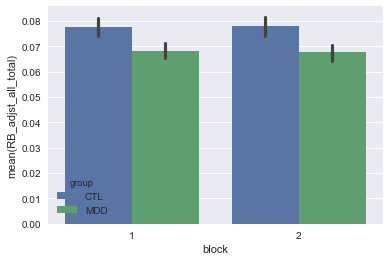

In [359]:
total_rb_plot = sns.barplot(y='RB_adjst_all_total', x = 'block', hue = 'group', data = data, ci=68)

%Rpush data
%R rb.aov <- aov_ez("subjectID", dv = "RB_adjst_all_block", \
                                 data = data, within = "block", \
                                 between = "group",anova_table=list(correction="GG", es = "pes"))
%R print(rb.aov)

Nothing with block 2 - block1 

In [363]:
%Rpush data
%R rb.aov <- aov_ez("subjectID", dv = "RB_b2_minus_b1", \
                                 data = data, between = "group",anova_table=list(correction="GG", es = "pes"))
%R print(rb.aov)

Anova Table (Type 3 tests)

Response: RB_b2_minus_b1
  Effect    df  MSE    F pes p.value
1  group 1, 69 0.05 2.30 .03     .13


Worse discriminability in the second block, no effect of group

Anova Table (Type 3 tests)

Response: dis_adjst_all_block
       Effect    df  MSE       F  pes p.value
1       group 1, 69 0.08    0.16 .002     .69
2       block 1, 69 0.02 9.27 **  .12    .003
3 group:block 1, 69 0.02    0.69 .010     .41

Sphericity correction method: GG 


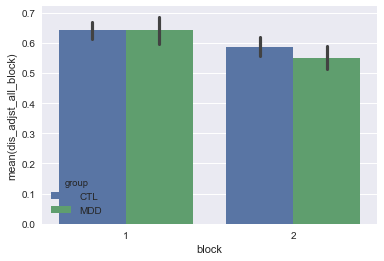

In [365]:
plot = sns.barplot(y='dis_adjst_all_block', x = 'block', 
                                   data = data, hue = 'group', ci=68, units= 'subjectID')
%Rpush data
%R discriminability.aov <- aov_ez("subjectID", dv = "dis_adjst_all_block", \
                                 data = data, within = 'block',\
                                 between = "group",anova_table=list(correction="GG", es = "pes"))
%R print (discriminability.aov)

Faster RTs in the second block, no effect of group.

Anova Table (Type 3 tests)

Response: ln_rt
       Effect    df  MSE      F  pes p.value
1       group 1, 69 0.08   1.52  .02     .22
2       block 1, 69 0.01 5.82 *  .08     .02
3 group:block 1, 69 0.01   0.35 .005     .55

Sphericity correction method: GG 


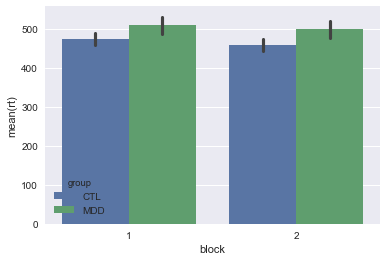

In [366]:
rt_plot = sns.barplot(y='rt', x = 'block', hue = 'group', data=data,  \
                      ci=68, units = 'subjectID')

%Rpush data
%R rt.aov <- aov_ez("subjectID", dv = "ln_rt", \
                                 data = data, within = 'block',\
                                 between = 'group',anova_table=list(correction="GG", es = "pes"))
%R print (rt.aov)

Reward recieved: no effect of group

Lunch break to do:  
Create a reward count variable  


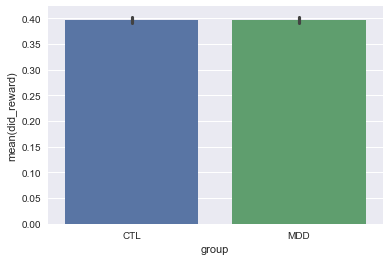

In [374]:
rw_ct = sns.barplot(y='did_reward', x = 'group', 
                                   data = data, ci=68, units = 'subjectID')
#%Rpush embarc_standard_forR
#%R embarc_rb_b1.aov <- aov_ez("ProjectSpecificID", dv = "rwdct1_Total", data = embarc_standard_forR, \
                         #     between = c("feasibility","site"),\
                          #    anova_table=list(correction="GG", es = "pes"))
#%R print (embarc_rb_b1.aov)

In [373]:
data.groupby(['group']).did_reward.mean()

group
CTL    0.396616
MDD    0.397125
Name: did_reward, dtype: float64

### HDDM

In [376]:
# getting the data HDDM compatible

data.loc[data.rl_resp == 'rich_resp', 'response'] = 1
data.loc[data.rl_resp == 'lean_resp', 'response'] = 0
data.loc[data.rl_stim == 'rich_stim', 'stim'] = 1
data.loc[data.rl_stim == 'lean_stim', 'stim'] = 0
data.rename(columns={'subjectID': 'subj_idx'}, inplace=True)
data['rt'] = data.rt/1000
data.to_csv(path2data + 'session1_hddm_ready.csv')

In [377]:
data = hddm.load_csv(path2data + 'session1_hddm_ready.csv')

In [385]:
session1_model = hddm.HDDMStimCoding(data, include='z', stim_col='stim', split_param='v',depends_on={'v': 'group', 'a': 'group', 't': 'group', 'z': 'group'})
session1_model.find_starting_values()
session1_model.sample(10000, burn=1000)

 [-----------------100%-----------------] 10001 of 10000 complete in 3171.8 sec

Plotting a(CTL)
Plotting a(MDD)
Plotting a_std
Plotting v(CTL)
Plotting v(MDD)
Plotting t(CTL)
Plotting t(MDD)


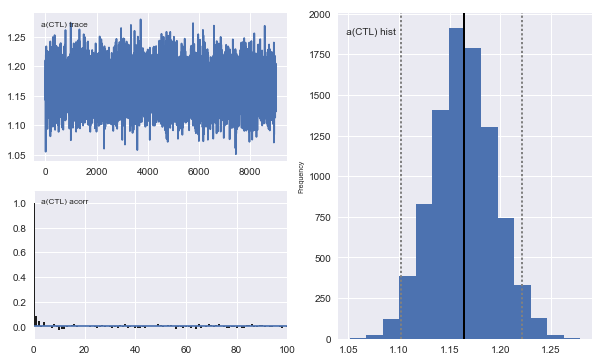

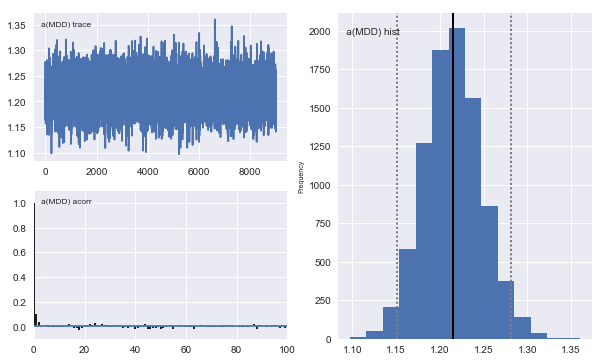

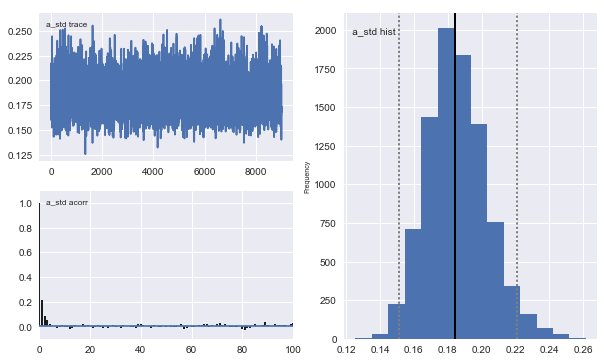

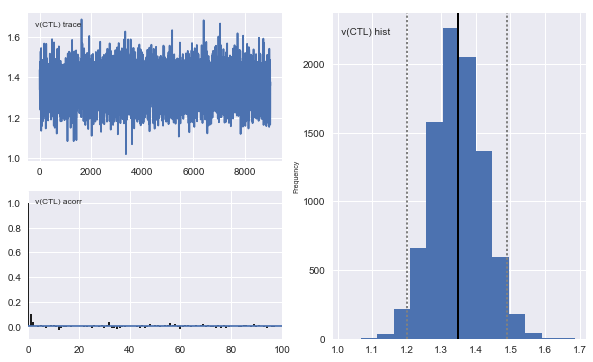

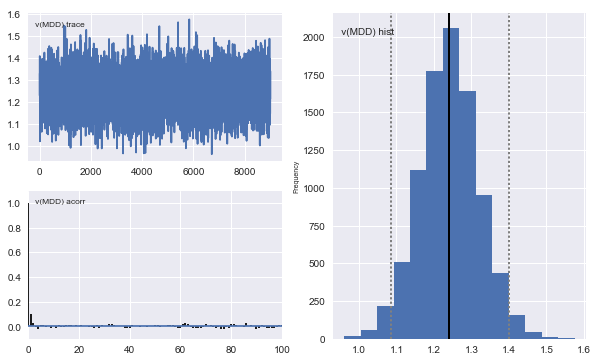

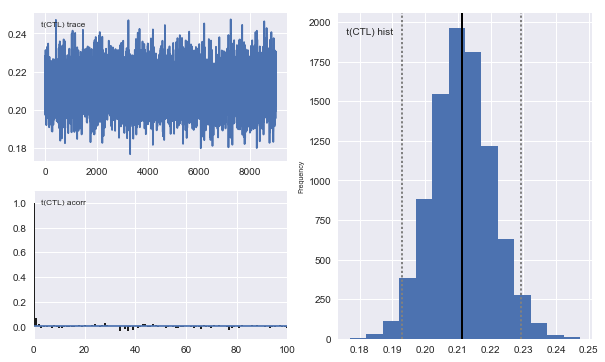

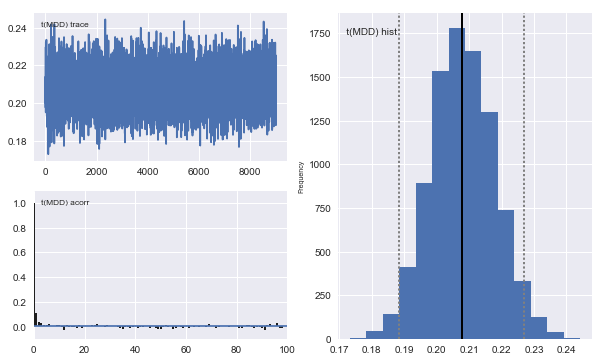

In [390]:
session1_model.plot_posteriors(['a', 't', 'v', 'a_std'])

P_a(MDD > CON) =  0.873222222222
P_a(CON > MDD) =  0.126777777778


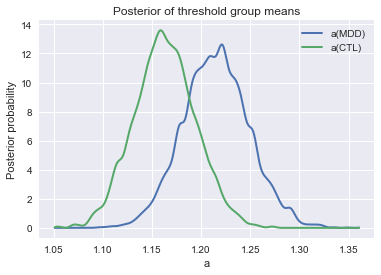

In [386]:
a_MDD, a_CON = session1_model.nodes_db.node[['a(MDD)','a(CTL)']]
hddm.analyze.plot_posterior_nodes([a_MDD, a_CON])
plt.xlabel('a')
plt.ylabel('Posterior probability')
plt.title('Posterior of threshold group means')

print ("P_a(MDD > CON) = ", (a_MDD.trace() > a_CON.trace()).mean())
print ("P_a(CON > MDD) = ", (a_CON.trace() > a_MDD.trace()).mean())

P_a(MDD > CON) =  0.161222222222
P_a(CON > MDD) =  0.838777777778


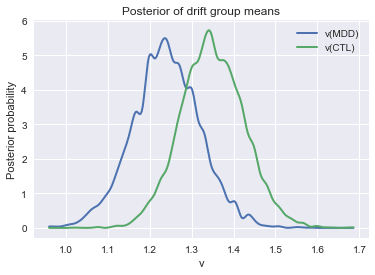

In [387]:
v_MDD, v_CON = session1_model.nodes_db.node[['v(MDD)','v(CTL)']]
hddm.analyze.plot_posterior_nodes([v_MDD, v_CON])
plt.xlabel('v')
plt.ylabel('Posterior probability')
plt.title('Posterior of drift group means')

print ("P_a(MDD > CON) = ", (v_MDD.trace() > v_CON.trace()).mean())
print ("P_a(CON > MDD) = ", (v_CON.trace() > v_MDD.trace()).mean())

P_a(MDD > CON) =  0.689
P_a(CON > MDD) =  0.311


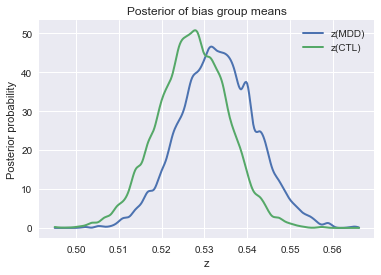

In [388]:
z_MDD, z_CON = session1_model.nodes_db.node[['z(MDD)','z(CTL)']]
hddm.analyze.plot_posterior_nodes([z_MDD, z_CON])
plt.xlabel('z')
plt.ylabel('Posterior probability')
plt.title('Posterior of bias group means')

print ("P_a(MDD > CON) = ", (z_MDD.trace() > z_CON.trace()).mean())
print ("P_a(CON > MDD) = ", (z_CON.trace() > z_MDD.trace()).mean())

P_a(MDD > CON) =  0.401555555556
P_a(CON > MDD) =  0.598444444444


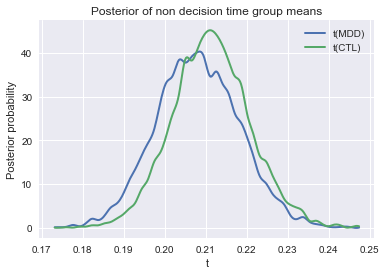

In [389]:
t_MDD, t_CON = session1_model.nodes_db.node[['t(MDD)','t(CTL)']]
hddm.analyze.plot_posterior_nodes([t_MDD, t_CON])
plt.xlabel('t')
plt.ylabel('Posterior probability')
plt.title('Posterior of non decision time group means')

print ("P_a(MDD > CON) = ", (t_MDD.trace() > t_CON.trace()).mean())
print ("P_a(CON > MDD) = ", (t_CON.trace() > t_MDD.trace()).mean())

Get subject means

In [460]:
stats = session1_model.gen_stats()
stats.to_csv(path2data + 'session1_modelstats.csv')
stats = pd.read_csv(path2data + 'session1_modelstats.csv')
stats.rename(columns={'Unnamed: 0': 'to_extract'}, inplace=True)
stats.head(5)

,to_extract,mean,std,2.5q,25q,50q,75q,97.5q,mc err
0,a(CTL),1.164097,0.030618,1.104655,1.143566,1.163722,1.184249,1.225103,0.000351
1,a(MDD),1.214888,0.033088,1.151180,1.192542,1.214828,1.236638,1.281591,0.000377
2,a_std,0.185441,0.017714,0.153918,0.173259,0.184195,0.196270,0.224496,0.000257
3,a_subj(CTL).DTC020,1.299195,0.050385,1.203835,1.263610,1.298089,1.333288,1.400292,0.000642
4,a_subj(CTL).DTC021,1.259265,0.047173,1.169054,1.227291,1.257858,1.289939,1.355685,0.000671


In [461]:
sess1 = pd.read_csv('/Users/victorialawlor/Work/Expts/KIDPRT/Data/session1_trial_clean.csv')

In [462]:
# Need to change length here

def get_param(item):
    '''Returns the parameter from the genstats() data'''
    if len(item) == 18:
        param = item[0]
    else:
        param = np.nan
    return(param)
def get_id(item):
    '''Returns the id info from the genstats() data'''
    if len(item) == 18:
        sub_id = item[12:18]
    else:
        sub_id = np.nan
    return(sub_id)

In [463]:
# get column info and merge this with the behavioral data

reward_stats = stats[['to_extract', 'mean']]
reward_stats['param'] = reward_stats.to_extract.apply(get_param)
reward_stats['subj_idx'] = reward_stats.to_extract.apply(get_id)
sess1['subj_idx'] = sess1.subjectID.apply(lambda x: str(x))
sess1_summary = sess1.drop_duplicates('subj_idx')
reward_stats = pd.merge(reward_stats, sess1_summary, on='subj_idx')
reward_stats.head()

,to_extract,mean,param,subj_idx,Unnamed: 0,Unnamed: 0.1,index,rt,little_due,big_due,...,bias,rl_stim,rich_key,rl_resp,block,ln_rt,outlier,mean_ln_rt,ln_std,outlier_sub
0,a_subj(CTL).DTC020,1.299195,a,DTC020,0,0,0,670,0,0,...,long,lean_stim,c,lean_resp,1,6.507278,0,6.111284,0.277035,0
1,v_subj(CTL).DTC020,1.378730,v,DTC020,0,0,0,670,0,0,...,long,lean_stim,c,lean_resp,1,6.507278,0,6.111284,0.277035,0
2,t_subj(CTL).DTC020,0.170576,t,DTC020,0,0,0,670,0,0,...,long,lean_stim,c,lean_resp,1,6.507278,0,6.111284,0.277035,0
3,z_subj(CTL).DTC020,0.437384,z,DTC020,0,0,0,670,0,0,...,long,lean_stim,c,lean_resp,1,6.507278,0,6.111284,0.277035,0
4,a_subj(CTL).DTC021,1.259265,a,DTC021,196,200,200,1172,0,0,...,short,rich_stim,c,lean_resp,1,7.066467,0,6.225349,0.338779,0


In [464]:
# get the data into usable form 
reward_stats_v = reward_stats[reward_stats['param'] == 'v']
reward_stats_a = reward_stats[reward_stats['param'] == 'a']
reward_stats_z = reward_stats[reward_stats['param'] == 'z']
reward_stats_v.rename(columns={'mean':'mean_v'}, inplace = True)
reward_stats_a.rename(columns={'mean':'mean_a'}, inplace = True)
reward_stats_z.rename(columns={'mean':'mean_z'}, inplace = True)
reward_stats = reward_stats_v.merge(reward_stats_a[['mean_a', 'subj_idx']], on = 'subj_idx')
reward_stats = reward_stats.merge(reward_stats_z[['mean_z', 'subj_idx']], on = 'subj_idx')
del reward_stats['param']
reward_stats.head(10)

,to_extract,mean_v,subj_idx,Unnamed: 0,Unnamed: 0.1,index,rt,little_due,big_due,trial,...,rich_key,rl_resp,block,ln_rt,outlier,mean_ln_rt,ln_std,outlier_sub,mean_a,mean_z
0,v_subj(CTL).DTC020,1.378730,DTC020,0,0,0,670,0,0,1,...,c,lean_resp,1,6.507278,0,6.111284,0.277035,0,1.299195,0.437384
1,v_subj(CTL).DTC021,1.445843,DTC021,196,200,200,1172,0,0,1,...,c,lean_resp,1,7.066467,0,6.225349,0.338779,0,1.259265,0.575523
2,v_subj(CTL).DTC022,0.843091,DTC022,395,400,400,920,0,0,1,...,m,lean_resp,1,6.824374,0,6.603664,0.363339,0,1.595259,0.545022
3,v_subj(CTL).DTC023,1.375186,DTC023,592,600,600,587,1,0,1,...,m,rich_resp,1,6.375025,0,6.177881,0.303305,0,1.088183,0.522977
4,v_subj(CTL).DTC024,1.747957,DTC024,790,800,800,575,0,0,1,...,c,lean_resp,1,6.354370,0,6.058692,0.266612,0,1.088731,0.548859
5,v_subj(CTL).DTC025,1.632723,DTC025,986,1000,1000,608,0,0,1,...,c,rich_resp,1,6.410175,0,6.006471,0.264405,0,1.154896,0.593357
6,v_subj(CTL).DTC026,1.277700,DTC026,1183,1200,1200,515,0,0,1,...,m,lean_resp,1,6.244167,0,6.155727,0.374361,0,1.224471,0.394559
7,v_subj(CTL).DTC027,1.174098,DTC027,1379,1400,1400,786,0,0,1,...,m,rich_resp,1,6.666957,0,6.233220,0.321673,0,1.257903,0.621666
8,v_subj(CTL).DTC029,1.331318,DTC029,1579,1600,1600,728,0,0,1,...,c,lean_resp,1,6.590301,0,6.362719,0.350666,0,1.364926,0.454907
9,v_subj(CTL).DTC030,1.760363,DTC030,1777,1800,1800,615,0,0,1,...,c,rich_resp,1,6.421622,0,6.184121,0.270475,0,1.190520,0.541289


In [465]:
reward_stats.to_csv(path2data + 'session1_hddm_params.csv')

# Follow-up

In [514]:
data = pd.read_csv('/Users/victorialawlor/Work/Expts/KIDPRT/Data/session2_trial_clean.csv')

In [515]:
data.groupby('group').subjectID.nunique()

group
CTL    33
MDD    20
Name: subjectID, dtype: int64

### Participant Characteristics

### Standard Analysis

Both groups develop a response bias

In [402]:
data_mdd = data.loc[data.group == 'MDD']
%Rpush data_mdd
%R rb.test <- t.test(data_mdd$RB_adjst_all_block, mu=0, alternative="greater")
%R print (rb.test)


	One Sample t-test

data:  data_mdd$RB_adjst_all_block
t = 35.408, df = 3954, p-value < 2.2e-16
alternative hypothesis: true mean is greater than 0
95 percent confidence interval:
 0.1005101       Inf
sample estimates:
mean of x 
0.1054079 



In [403]:
data_ctl = data.loc[data.group == 'CTL']
%Rpush data_ctl
%R rb.test <- t.test(data_ctl$RB_adjst_all_block, mu=0, alternative="greater")
%R print (rb.test)


	One Sample t-test

data:  data_ctl$RB_adjst_all_block
t = 21.472, df = 6505, p-value < 2.2e-16
alternative hypothesis: true mean is greater than 0
95 percent confidence interval:
 0.05540865        Inf
sample estimates:
 mean of x 
0.06000615 



Anova Table (Type 3 tests)

Response: RB_adjst_all_block
       Effect    df  MSE    F   pes p.value
1       group 1, 51 0.07 0.76   .01     .39
2       block 1, 51 0.03 0.04 .0007     .85
3 group:block 1, 51 0.03 0.08  .002     .78

Sphericity correction method: GG 


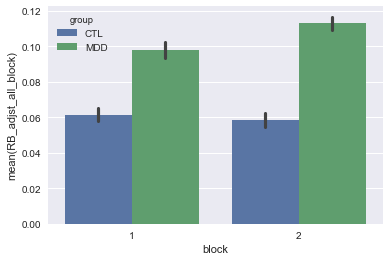

In [405]:
total_rb_plot = sns.barplot(y='RB_adjst_all_block', x = 'block', hue = 'group', data = data, ci=68)

%Rpush data
%R rb.aov <- aov_ez("subjectID", dv = "RB_adjst_all_block", \
                                 data = data, within = "block", \
                                 between = "group",anova_table=list(correction="GG", es = "pes"))
%R print(rb.aov)

In [406]:
%Rpush data
%R rb.aov <- aov_ez("subjectID", dv = "RB_b2_minus_b1", \
                                 data = data, between = "group",anova_table=list(correction="GG", es = "pes"))
%R print(rb.aov)

Anova Table (Type 3 tests)

Response: RB_b2_minus_b1
  Effect    df  MSE    F  pes p.value
1  group 1, 51 0.05 0.08 .002     .78


Anova Table (Type 3 tests)

Response: dis_adjst_all_block
       Effect    df  MSE       F  pes p.value
1       group 1, 51 0.08    0.25 .005     .62
2       block 1, 51 0.01 9.73 **  .16    .003
3 group:block 1, 51 0.01    1.33  .03     .25

Sphericity correction method: GG 


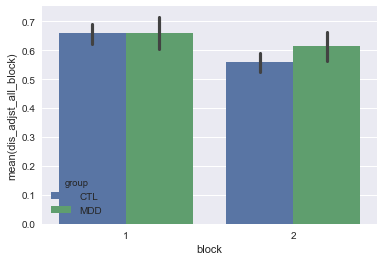

In [407]:
plot = sns.barplot(y='dis_adjst_all_block', x = 'block', 
                                   data = data, hue = 'group', ci=68, units= 'subjectID')
%Rpush data
%R discriminability.aov <- aov_ez("subjectID", dv = "dis_adjst_all_block", \
                                 data = data, within = 'block',\
                                 between = "group",anova_table=list(correction="GG", es = "pes"))
%R print (discriminability.aov)

Anova Table (Type 3 tests)

Response: ln_rt
       Effect    df  MSE      F pes p.value
1       group 1, 51 0.07 4.68 * .08     .04
2       block 1, 51 0.01 5.86 * .10     .02
3 group:block 1, 51 0.01   0.69 .01     .41

Sphericity correction method: GG 


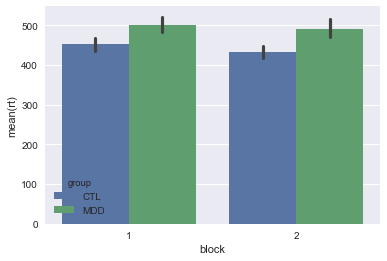

In [408]:
rt_plot = sns.barplot(y='rt', x = 'block', hue = 'group', data=data,  \
                      ci=68, units = 'subjectID')

%Rpush data
%R rt.aov <- aov_ez("subjectID", dv = "ln_rt", \
                                 data = data, within = 'block',\
                                 between = 'group',anova_table=list(correction="GG", es = "pes"))
%R print (rt.aov)

### HDDM

In [409]:
# getting the data HDDM compatible

data.loc[data.rl_resp == 'rich_resp', 'response'] = 1
data.loc[data.rl_resp == 'lean_resp', 'response'] = 0
data.loc[data.rl_stim == 'rich_stim', 'stim'] = 1
data.loc[data.rl_stim == 'lean_stim', 'stim'] = 0
data.rename(columns={'subjectID': 'subj_idx'}, inplace=True)
data['rt'] = data.rt/1000
data.to_csv(path2data + 'session2_hddm_ready.csv')

In [410]:
data = hddm.load_csv(path2data + 'session2_hddm_ready.csv')

In [416]:
session2_model = hddm.HDDMStimCoding(data, include='z', stim_col='stim', split_param='v',depends_on={'v': 'group', 'a': 'group', 't': 'group', 'z': 'group'})
session2_model.find_starting_values()
session2_model.sample(10000, burn=1000)

 [-----------------100%-----------------] 10000 of 10000 complete in 1590.2 sec

P_a(MDD > CON) =  0.993333333333
P_a(CON > MDD) =  0.00666666666667


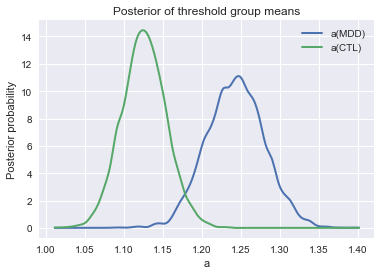

In [417]:
a_MDD, a_CON = session2_model.nodes_db.node[['a(MDD)','a(CTL)']]
hddm.analyze.plot_posterior_nodes([a_MDD, a_CON])
plt.xlabel('a')
plt.ylabel('Posterior probability')
plt.title('Posterior of threshold group means')

print ("P_a(MDD > CON) = ", (a_MDD.trace() > a_CON.trace()).mean())
print ("P_a(CON > MDD) = ", (a_CON.trace() > a_MDD.trace()).mean())

P_a(MDD > CON) =  0.442
P_a(CON > MDD) =  0.558


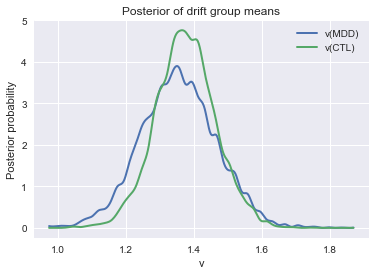

In [418]:
v_MDD, v_CON = session2_model.nodes_db.node[['v(MDD)','v(CTL)']]
hddm.analyze.plot_posterior_nodes([v_MDD, v_CON])
plt.xlabel('v')
plt.ylabel('Posterior probability')
plt.title('Posterior of drift group means')

print ("P_a(MDD > CON) = ", (v_MDD.trace() > v_CON.trace()).mean())
print ("P_a(CON > MDD) = ", (v_CON.trace() > v_MDD.trace()).mean())

P_a(MDD > CON) =  0.691666666667
P_a(CON > MDD) =  0.308333333333


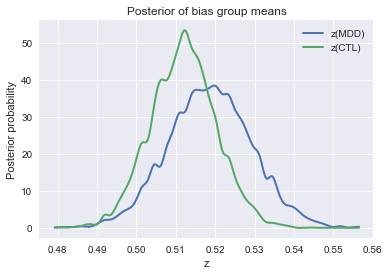

In [419]:
z_MDD, z_CON = session2_model.nodes_db.node[['z(MDD)','z(CTL)']]
hddm.analyze.plot_posterior_nodes([z_MDD, z_CON])
plt.xlabel('z')
plt.ylabel('Posterior probability')
plt.title('Posterior of bias group means')

print ("P_a(MDD > CON) = ", (z_MDD.trace() > z_CON.trace()).mean())
print ("P_a(CON > MDD) = ", (z_CON.trace() > z_MDD.trace()).mean())

P_a(MDD > CON) =  0.676777777778
P_a(CON > MDD) =  0.323222222222


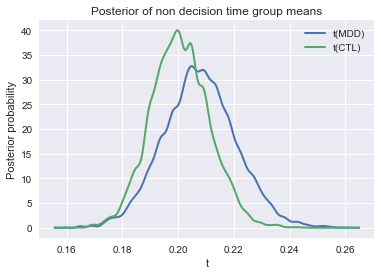

In [442]:
t_MDD, t_CON = session2_model.nodes_db.node[['t(MDD)','t(CTL)']]
hddm.analyze.plot_posterior_nodes([t_MDD, t_CON])
plt.xlabel('t')
plt.ylabel('Posterior probability')
plt.title('Posterior of non decision time group means')

print ("P_a(MDD > CON) = ", (t_MDD.trace() > t_CON.trace()).mean())
print ("P_a(CON > MDD) = ", (t_CON.trace() > t_MDD.trace()).mean())

In [451]:
sess2 = pd.read_csv('/Users/victorialawlor/Work/Expts/KIDPRT/Data/session2_trial_clean.csv')

In [471]:
stats = session2_model.gen_stats()
stats.to_csv(path2data + 'session2_modelstats.csv')
stats = pd.read_csv(path2data + 'session2_modelstats.csv')
stats.rename(columns={'Unnamed: 0': 'to_extract'}, inplace=True)
stats.head(5)

,to_extract,mean,std,2.5q,25q,50q,75q,97.5q,mc err
0,a(CTL),1.127676,0.028231,1.072920,1.108966,1.127644,1.146302,1.184455,0.000317
1,a(MDD),1.242494,0.036427,1.172983,1.217971,1.242596,1.266785,1.314129,0.000404
2,a_std,0.156484,0.017307,0.126344,0.144405,0.155051,0.167055,0.194357,0.000226
3,a_subj(CTL).DTC020,0.973029,0.036292,0.904643,0.947902,0.972325,0.996971,1.047549,0.000548
4,a_subj(CTL).DTC021,1.154010,0.047526,1.066172,1.121438,1.152093,1.184596,1.254532,0.000708


In [472]:
# get column info and merge this with the behavioral data

reward_stats = stats[['to_extract', 'mean']]
reward_stats['param'] = reward_stats.to_extract.apply(get_param)
reward_stats['subj_idx'] = reward_stats.to_extract.apply(get_id)
sess2['subj_idx'] = sess2.subjectID.apply(lambda x: str(x))
sess2_summary = sess2.drop_duplicates('subj_idx')
reward_stats = pd.merge(reward_stats, sess2_summary, on='subj_idx')
reward_stats.head()

,to_extract,mean,param,subj_idx,Unnamed: 0,Unnamed: 0.1,index,rt,little_due,big_due,...,ln_rt,outlier,mean_ln_rt,ln_std,outlier_sub,RB_adjst_all_total,dis_adjst_all_total,RB_adjst_all_block,dis_adjst_all_block,RB_b2_minus_b1
0,a_subj(CTL).DTC020,0.973029,a,DTC020,0,0,0,661,0,0,...,6.493754,0,5.748988,0.319394,0,-0.005830,0.539679,-0.128076,0.593459,0.225768
1,v_subj(CTL).DTC020,1.373494,v,DTC020,0,0,0,661,0,0,...,6.493754,0,5.748988,0.319394,0,-0.005830,0.539679,-0.128076,0.593459,0.225768
2,t_subj(CTL).DTC020,0.131828,t,DTC020,0,0,0,661,0,0,...,6.493754,0,5.748988,0.319394,0,-0.005830,0.539679,-0.128076,0.593459,0.225768
3,z_subj(CTL).DTC020,0.528460,z,DTC020,0,0,0,661,0,0,...,6.493754,0,5.748988,0.319394,0,-0.005830,0.539679,-0.128076,0.593459,0.225768
4,a_subj(CTL).DTC021,1.154010,a,DTC021,190,200,200,440,0,0,...,6.086775,0,6.097973,0.236966,0,0.284238,0.878280,0.262187,1.025615,0.023085


In [473]:
# get the data into usable form 
reward_stats_v = reward_stats[reward_stats['param'] == 'v']
reward_stats_a = reward_stats[reward_stats['param'] == 'a']
reward_stats_z = reward_stats[reward_stats['param'] == 'z']
reward_stats_v.rename(columns={'mean':'mean_v2'}, inplace = True)
reward_stats_a.rename(columns={'mean':'mean_a2'}, inplace = True)
reward_stats_z.rename(columns={'mean':'mean_z2'}, inplace = True)
reward_stats = reward_stats_v.merge(reward_stats_a[['mean_a2', 'subj_idx']], on = 'subj_idx')
reward_stats = reward_stats.merge(reward_stats_z[['mean_z2', 'subj_idx']], on = 'subj_idx')
del reward_stats['param']
reward_stats.head()

,to_extract,mean_v2,subj_idx,Unnamed: 0,Unnamed: 0.1,index,rt,little_due,big_due,trial,...,mean_ln_rt,ln_std,outlier_sub,RB_adjst_all_total,dis_adjst_all_total,RB_adjst_all_block,dis_adjst_all_block,RB_b2_minus_b1,mean_a2,mean_z2
0,v_subj(CTL).DTC020,1.373494,DTC020,0,0,0,661,0,0,1,...,5.748988,0.319394,0,-0.005830,0.539679,-0.128076,0.593459,0.225768,0.973029,0.528460
1,v_subj(CTL).DTC021,1.826776,DTC021,190,200,200,440,0,0,1,...,6.097973,0.236966,0,0.284238,0.878280,0.262187,1.025615,0.023085,1.154010,0.496617
2,v_subj(CTL).DTC022,1.810926,DTC022,390,400,400,708,0,0,1,...,6.152736,0.199102,0,0.269444,0.826307,0.221998,0.910627,0.069142,1.170257,0.495701
3,v_subj(CTL).DTC023,1.586489,DTC023,588,600,600,450,0,0,1,...,5.952972,0.220111,0,0.068148,0.605268,0.046916,0.582815,0.040187,1.045029,0.530512
4,v_subj(CTL).DTC024,1.362379,DTC024,786,800,800,440,0,0,1,...,5.704769,0.210237,0,0.062446,0.426335,0.023674,0.512225,0.069949,0.849355,0.537928


In [474]:
reward_stats.to_csv(path2data + 'session2_hddm_params.csv')

# HDDM Stability

In [475]:
sess1_params = pd.read_csv(path2data + 'session1_hddm_params.csv')
sess2_params = pd.read_csv(path2data + 'session2_hddm_params.csv')

In [476]:
all_params = pd.merge(sess1_params[['subj_idx','mean_v', 'mean_z', 'mean_a']], \
                      sess2_params, on= 'subj_idx')


	Pearson's product-moment correlation

data:  all_params$mean_v and all_params$mean_v2
t = 4.6819, df = 46, p-value = 2.535e-05
alternative hypothesis: true correlation is not equal to 0
95 percent confidence interval:
 0.3386165 0.7337843
sample estimates:
      cor 
0.5680934 



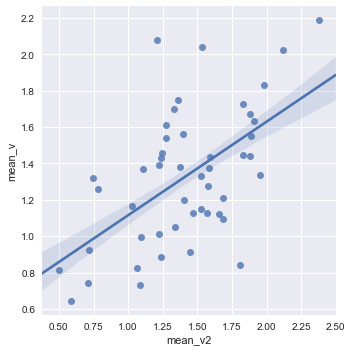

In [486]:
corr_param = sns.lmplot(y='mean_v', \
                        x = 'mean_v2', data=all_params,ci=68, \
                        units = 'subj_idx')
%Rpush all_params
%R rl_disc.cor <- cor.test(all_params$mean_v,all_params$mean_v2,method="pearson")
%R print (rl_disc.cor)


	Pearson's product-moment correlation

data:  all_params$mean_a and all_params$mean_a2
t = 3.2284, df = 46, p-value = 0.002298
alternative hypothesis: true correlation is not equal to 0
95 percent confidence interval:
 0.1659248 0.6362344
sample estimates:
      cor 
0.4297967 



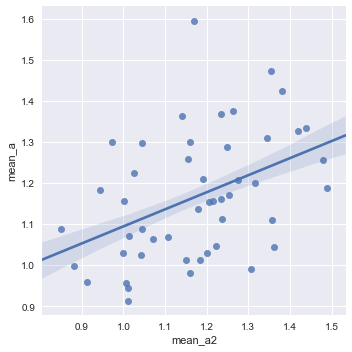

In [487]:
# RT correlation
corr_param = sns.lmplot(y='mean_a', \
                        x = 'mean_a2', data=all_params,ci=68, units = 'subj_idx')
%Rpush all_params
%R rl_disc.cor <- cor.test(all_params$mean_a,all_params$mean_a2,method="pearson")
%R print (rl_disc.cor)


	Pearson's product-moment correlation

data:  all_params$mean_z and all_params$mean_z2
t = -2.5641, df = 46, p-value = 0.01368
alternative hypothesis: true correlation is not equal to 0
95 percent confidence interval:
 -0.57953100 -0.07725365
sample estimates:
       cor 
-0.3536261 



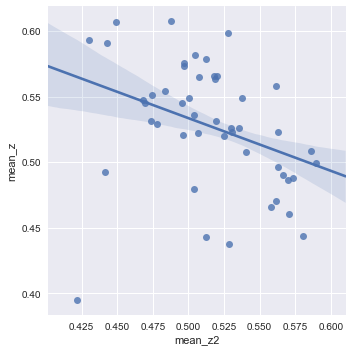

In [488]:
# RT correlation
corr_param = sns.lmplot(y='mean_z', \
                        x = 'mean_z2', data=all_params,ci=68, units = 'subj_idx')
%Rpush all_params
%R rl_disc.cor <- cor.test(all_params$mean_z,all_params$mean_z2,method="pearson")
%R print (rl_disc.cor)

## Clinical measures